### Import library yang dibutuhkan

In [13]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn. model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import pickle

### Download library NLTK

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [19]:
test_df = pd.read_csv('testAES.csv')



In [20]:
test_df

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


### Drop kolom yang tidak dibutuhkan

In [24]:
train_df = train_df.drop('essay_id', axis = 1)

In [25]:
train_df.head()

,full_text,score
0,Many people have car where they live. The thin...,3
1,I am a scientist at NASA that is discussing th...,3
2,People always wish they had the same technolog...,4
3,"We all heard about Venus, the planet without a...",4
4,"Dear, State Senator\n\nThis is a letter to arg...",3


### Preprocessing Data

In [21]:
def preprocessing_text(text):
  text = re.sub(r'\W', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  text = text.lower()
  tokens = nltk.word_tokenize(text)
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
  return ' '.join(tokens)

In [22]:
test_df['cleaned_text'] = test_df['full_text'].apply(preprocessing_text)


test_df

,essay_id,full_text,cleaned_text
0,000d118,Many people have car where they live. The thin...,many people car live thing know use car alot t...
1,000fe60,I am a scientist at NASA that is discussing th...,scientist nasa discussing face mar explaining ...
2,001ab80,People always wish they had the same technolog...,people always wish technology seen movie best ...


### Feature Extraction 

In [23]:
vectorizer = HashingVectorizer(n_features = 300)

X = vectorizer.fit_transform(test_df['cleaned_text']).toarray()


In [24]:
model = pickle.load(open('stackingfinal.pkl','rb'))
y_pred = model.predict(X)

In [25]:
test_df['score'] = y_pred
test_df.drop('cleaned_text',axis=1)

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,2
1,000fe60,I am a scientist at NASA that is discussing th...,1
2,001ab80,People always wish they had the same technolog...,2


In [ ]:
sub

### HANDLING IMBALANCE DATA

In [30]:
target_sample = 2884

sampling_strategy = {1:target_sample,5:target_sample,6:target_sample}

sm = SMOTE(sampling_strategy = sampling_strategy, random_state=42)

x_res,y_res = sm.fit_resample(X,y)

In [31]:
sampling_strategy_down = {2:target_sample,3:target_sample,4:target_sample}
ros = RandomUnderSampler(sampling_strategy = sampling_strategy_down,random_state = 42)
x_res,y_res = ros.fit_resample(x_res,y_res)

### SETELAH HANDLE IMBALANCE DATA

In [32]:
y_res.value_counts()

1    2884
2    2884
3    2884
4    2884
5    2884
6    2884
Name: score, dtype: int64

### Train Test Split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2)


### FUNGSI CONFUSION MATRIX

In [34]:
def create_confusion_matrix(y_true, y_pred):

    labels = np.unique(np.concatenate((y_true, y_pred)))
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return cm_df


In [48]:
rfc = RandomForestClassifier(random_state=42,n_jobs = -1)
param_grid_rf={
    'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],
    'max_features' : ['sqrt',None,'log2'],
    'max_depth': [int(x) for x in np.linspace(start = 10, stop = 500, num = 5)],
    'min_samples_split': [2,4,5,9],
    'min_samples_leaf': [2,6,8,9]
   
}
skf = StratifiedKFold(n_splits=3,random_state=42,shuffle=True) 
random_search_rf = RandomizedSearchCV(estimator = rfc, param_distributions= param_grid_rf,n_iter=10,verbose=2, cv=skf,n_jobs=1)
random_search_rf.fit(X_train,y_train)
best_random_rf = random_search_rf.best_estimator_
print(best_random_rf)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=377, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=400; total time=   2.5s
[CV] END max_depth=377, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=400; total time=   1.5s
[CV] END max_depth=377, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=400; total time=   1.5s
[CV] END max_depth=500, max_features=log2, min_samples_leaf=9, min_samples_split=9, n_estimators=800; total time=   2.7s
[CV] END max_depth=500, max_features=log2, min_samples_leaf=9, min_samples_split=9, n_estimators=800; total time=   2.4s
[CV] END max_depth=500, max_features=log2, min_samples_leaf=9, min_samples_split=9, n_estimators=800; total time=   2.6s
[CV] END max_depth=377, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=800; total time= 5.0min
[CV] END max_depth=377, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estima

RandomForestClassifier(max_depth=132, min_samples_leaf=6, min_samples_split=9,
                       n_estimators=400, n_jobs=-1, random_state=42)
Accuracy : 0.7208899162091881
Kappa Score : 0.6655966068016599


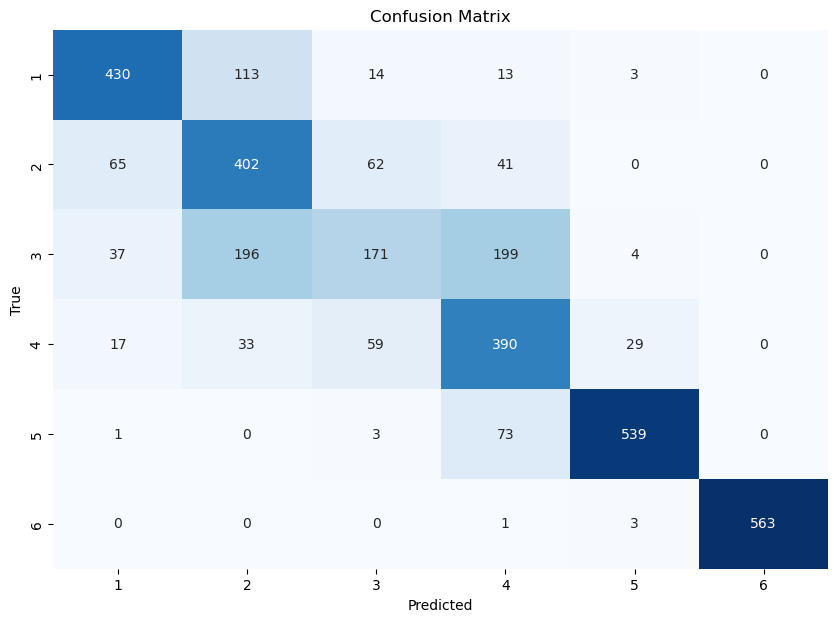

,1,2,3,4,5,6
1,430,113,14,13,3,0
2,65,402,62,41,0,0
3,37,196,171,199,4,0
4,17,33,59,390,29,0
5,1,0,3,73,539,0
6,0,0,0,1,3,563


In [49]:
y_pred = best_random_rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
kappa_score =  cohen_kappa_score(y_test, y_pred)

print(best_random_rf)
print(f'Accuracy : {acc}')
print(f'Kappa Score : {kappa_score}')
create_confusion_matrix(y_test,y_pred)

### UJI #1 ALGORITMA RANDOM FOREST DENGAN HYPERPARAMETER TUNING DENGAN BALANCED DATA

RandomForestClassifier(bootstrap=False, n_estimators=750, n_jobs=-1,
                       random_state=42)
Accuracy : 0.7526726379659058
Kappa Score : 0.7034667755664188


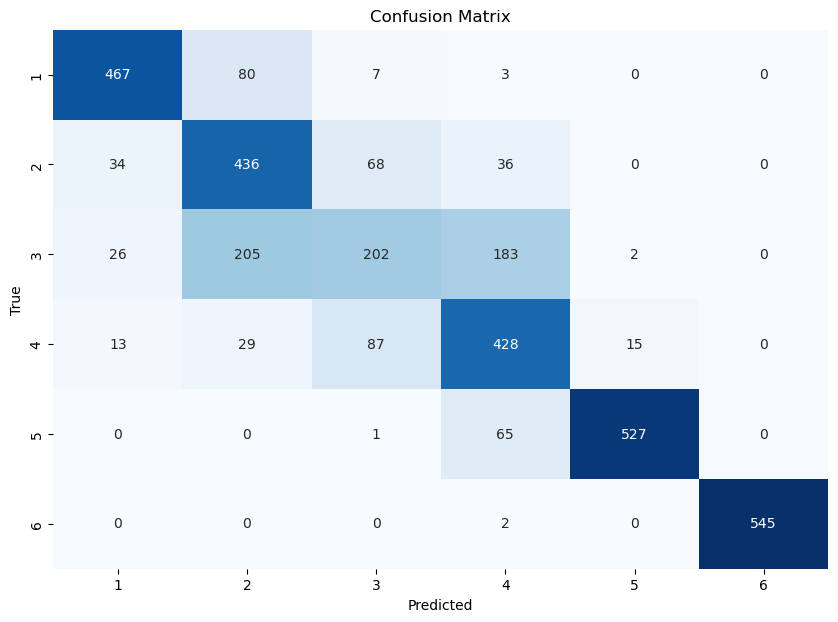

,1,2,3,4,5,6
1,467,80,7,3,0,0
2,34,436,68,36,0,0
3,26,205,202,183,2,0
4,13,29,87,428,15,0
5,0,0,1,65,527,0
6,0,0,0,2,0,545


In [16]:
rfc = RandomForestClassifier(random_state=42,n_jobs = -1)
param_grid_rf={
    'n_estimators' : [500,750,1000],
    'max_features' : ['sqrt'],
    'max_depth': [None],
    'bootstrap' : [False]
}
skf = StratifiedKFold(n_splits=3,random_state=42,shuffle=True) 
grid_search_rf = GridSearchCV(rfc, param_grid_rf, cv=skf,n_jobs=1)
grid_search_rf.fit(X_train,y_train)
best_rf = grid_search_rf.best_estimator_
y_pred = best_rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
kappa_score =  cohen_kappa_score(y_test, y_pred)

print(best_rf)
print(f'Accuracy : {acc}')
print(f'Kappa Score : {kappa_score}')
create_confusion_matrix(y_test,y_pred)


In [17]:
pprint(grid_search_rf.cv_results_)

{'mean_fit_time': array([10.70926619, 15.06545432, 17.21050978]),
 'mean_score_time': array([0.30934374, 0.45091836, 0.52737864]),
 'mean_test_score': array([0.7433356 , 0.74470801, 0.74369665]),
 'param_bootstrap': masked_array(data=[False, False, False],
             mask=[False, False, False],
       fill_value='?',
            dtype=object),
 'param_max_depth': masked_array(data=[None, None, None],
             mask=[False, False, False],
       fill_value='?',
            dtype=object),
 'param_max_features': masked_array(data=['sqrt', 'sqrt', 'sqrt'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object),
 'param_n_estimators': masked_array(data=[500, 750, 1000],
             mask=[False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'bootstrap': False,
             'max_depth': None,
             'max_features': 'sqrt',
             'n_estimators': 500},
            {'bootstrap': False,
             'max_depth':

### UJI #2 MENGGUNAKAN ALGORITMA LOGISTIC REGRESSION DENGAN HYPERPARAMETER TUNING DENGAN BALANCED DATA

LogisticRegression(C=1, max_iter=300, multi_class='multinomial',
                   random_state=42, solver='newton-cg')
Accuracy : 0.6353655013002023
Kappa Score : 0.56236561208348


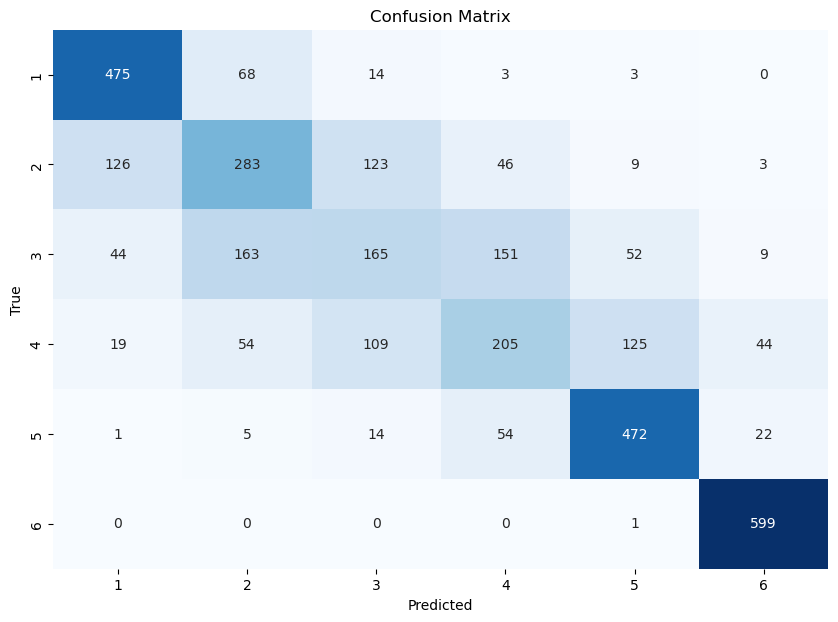

,1,2,3,4,5,6
1,475,68,14,3,3,0
2,126,283,123,46,9,3
3,44,163,165,151,52,9
4,19,54,109,205,125,44
5,1,5,14,54,472,22
6,0,0,0,0,1,599


In [32]:
lr = LogisticRegression(random_state=42,multi_class='multinomial')
param_grid_lr={
    'C': [1],
    'solver': ['newton-cg'],
    'max_iter': [300]
}
skf = StratifiedKFold(n_splits=3,random_state=42,shuffle=True) 
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=skf,n_jobs=-1)
grid_search_lr.fit(X_train,y_train)
best_lr = grid_search_lr.best_estimator_
y_pred = best_lr.predict(X_test)

acc = accuracy_score(y_test, y_pred)
kappa_score =  cohen_kappa_score(y_test, y_pred)

print(best_lr)
print(f'Accuracy : {acc}')
print(f'Kappa Score : {kappa_score}')
create_confusion_matrix(y_test,y_pred)

In [40]:
pprint(grid_search_lr.cv_results_)

{'mean_fit_time': array([16.95430835, 10.06989415, 19.44975607, 14.85728304,  8.09856025,
       18.3349882 , 14.65261213,  7.94756842, 17.93586882,  7.41244857,
        2.70339473, 16.8515083 ,  7.07458433,  2.74062967, 17.10648457,
        7.36093545,  2.69682455, 16.65924056, 28.50455205, 24.56464299,
       37.1315287 , 30.24005508, 24.4976186 , 36.91606379, 29.24160361,
       21.90027507, 29.21523205]),
 'mean_score_time': array([0.08749898, 0.09345134, 0.09236121, 0.10208837, 0.08504367,
       0.09474778, 0.10659385, 0.1001687 , 0.09181682, 0.09216873,
       0.05375457, 0.10284241, 0.08049703, 0.08816195, 0.08931573,
       0.0949839 , 0.08284028, 0.10263904, 0.1048363 , 0.12902832,
       0.10393135, 0.11020295, 0.10575167, 0.09100636, 0.11535406,
       0.06206632, 0.04769802]),
 'mean_test_score': array([0.48421578, 0.48421578, 0.48421578, 0.48421578, 0.48421578,
       0.48421578, 0.48421578, 0.48421578, 0.48421578, 0.37499071,
       0.37513519, 0.37520743, 0.37499071, 0.

### UJI 3 MENGGUNAKAN ALGORITMA XGBoost DENGAN HYPERPARAMETER TUNING DENGAN BALANCED DATA

/opt/homebrew/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:56:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:56:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:56:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:56:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              eval_metrics='mlogloss', feature_types=None, gamma=0.001,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=750, n_jobs=None,
              num_parallel_tree=None, ...)
Accuracy : 0.7457382259462583
Kappa Score : 0.6948929062760992


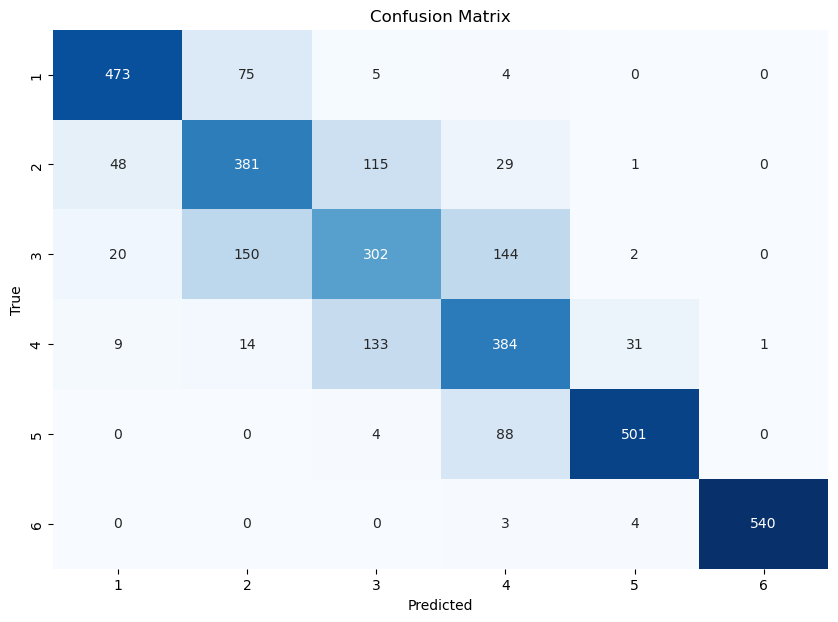

,1,2,3,4,5,6
1,473,75,5,4,0,0
2,48,381,115,29,1,0
3,20,150,302,144,2,0
4,9,14,133,384,31,1
5,0,0,4,88,501,0
6,0,0,0,3,4,540


In [18]:
from sklearn.preprocessing import LabelEncoder
xg_boost = XGBClassifier(random_state=42,eval_metrics='mlogloss')
param_grid_xgb={
    'n_estimators': [500,750,1000],
    'learning_rate': [0.1],
    'gamma': [0.001]
}
skf = StratifiedKFold(n_splits=3,random_state=42,shuffle=True) 
le = LabelEncoder()
y_train_xgb = le.fit_transform(y_train)
grid_search_xgb = GridSearchCV(xg_boost, param_grid_xgb, cv=skf,n_jobs=-1)
grid_search_xgb.fit(X_train,y_train_xgb)
best_xgb = grid_search_xgb.best_estimator_
y_pred = best_xgb.predict(X_test)
y_pred = le.inverse_transform(y_pred)

acc = accuracy_score(y_test, y_pred)
kappa_score =  cohen_kappa_score(y_test, y_pred)

print(best_xgb)
print(f'Accuracy : {acc}')
print(f'Kappa Score : {kappa_score}')
create_confusion_matrix(y_test,y_pred)

In [44]:
pprint(grid_search_xgb.cv_results_)

{'mean_fit_time': array([ 359.56918971,  796.99118646, 1849.21658969,  339.93394367,
        998.75887609, 3724.52106531,  361.87722643, 1155.83968107,
       3841.25676703,  391.84273092, 1147.32036901, 3545.16594871,
        374.68536226,  865.94660862, 1986.87626966,  357.0793554 ,
        971.49572865, 3561.553442  ,  356.10686366, 1095.68174585,
       3605.08419434,  367.32927632, 1079.48521439, 3388.05028407,
        338.55585265,  820.02136827, 1961.19501837,  356.17891939,
        954.24388544, 3539.85198307,  352.22879561, 1080.30613542,
       3138.01957059,  361.62334331, 1022.30671692, 1693.32899396]),
 'mean_score_time': array([0.19336526, 0.34921106, 0.65544756, 0.14558339, 0.23138436,
       0.66044497, 0.15406386, 0.325001  , 0.65688721, 0.22371443,
       0.38379471, 0.5257167 , 0.18377201, 0.45258093, 0.69746304,
       0.1256303 , 0.22102841, 0.66183631, 0.21637821, 0.35706902,
       0.70301255, 0.22928468, 0.33985368, 0.61174218, 0.22500507,
       0.37545172, 0.6

### UJI4 Ensemble learning metode stacking dengan parameter default, dengan final estimator XGBoost DENGAN BALANCED DATA

/opt/homebrew/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:49:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:57:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [02:04:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [02:10:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/

Score : 0.7752094770297602
Accuracy : 0.7752094770297602
Kappa Score : 0.7302346485221333
Training time :2464.8s


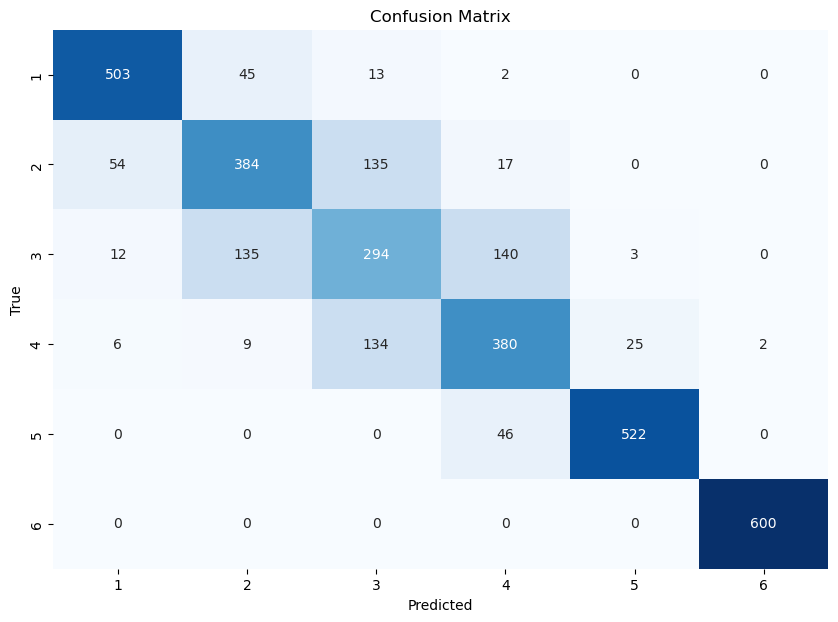

,1,2,3,4,5,6
1,503,45,13,2,0,0
2,54,384,135,17,0,0
3,12,135,294,140,3,0
4,6,9,134,380,25,2
5,0,0,0,46,522,0
6,0,0,0,0,0,600


In [43]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('xgb', best_xgb),
    ('rf', best_rf),
    ('lr', best_lr)
]

meta_model = best_xgb

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=meta_model )

start_time = datetime.now()
score = stacking_clf.fit(X_train, y_train).score(X_test, y_test)
end_time = datetime.now()

print(f'Score : {score}')

y_pred = stacking_clf.predict(X_test)
training_time = (end_time - start_time).total_seconds()
acc = accuracy_score(y_test, y_pred)
kappa_score =  cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy : {acc}')
print(f'Kappa Score : {kappa_score}')
print('Training time :{:.1f}s'.format(training_time))
create_confusion_matrix(y_test,y_pred)